In [180]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import numpy as np
import matplotlib.pyplot as plt


In [181]:
def dframe_to_dloader(*dframes: pd.DataFrame, batch_size: int, shuffle=True) -> data.DataLoader:
    tensors = [torch.tensor(df.values, dtype=torch.float) for df in dframes]

    tensor_dataset = data.TensorDataset(*tensors)

    return data.DataLoader(
        tensor_dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=False
    )

In [182]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
device = torch.device("cuda")

True
Tesla T4


In [183]:
bounds = [0, 100_000, 350_000, float('inf')]


In [184]:
num_cols = [
    'YearBuilt',
    'Size(sqf)',
    'Floor',
    'N_Parkinglot(Ground)',
    'N_Parkinglot(Basement)',
    'N_manager',
    'N_elevators',
    'N_FacilitiesInApt',
    'N_FacilitiesNearBy(Total)',
    'N_SchoolNearBy(Total)'
]

cat_cols = [
    'HallwayType',
    'HeatingType',
    'AptManageType',
    'TimeToBusStop',
    'TimeToSubway',
    'SubwayStation'
]

label_col = 'SalePrice'


In [185]:
def get_dataset(dframe):
    num_dframe = dframe[num_cols]
    cat_dframe = pd.get_dummies(dframe[cat_cols])
    labels_dframe = dframe[label_col]
    return num_dframe, cat_dframe, labels_dframe

In [186]:
class MLPClassifier(nn.Module):
    def __init__(
        self,
        layer_sizes: list[int],
        dropout: float
    ) -> None:
        super().__init__()

        self._linears = nn.ModuleList()
        self._normalizations = nn.ModuleList()

        size_pairs = list(zip(layer_sizes, layer_sizes[1:]))
        last_size_pair_index = len(size_pairs) - 1
        for i, (current_size, next_size) in enumerate(size_pairs):

            linear = nn.Linear(current_size, next_size)
            self._linears.append(linear)

             # Xavier initialization
            nn.init.xavier_uniform_(linear.weight)

            # Performed only on hidden layers
            if i != last_size_pair_index:
                # Batch normalization
                self._normalizations.append(nn.BatchNorm1d(next_size))

        # Dropout
        self._dropout = nn.Dropout(dropout)

        # Activation function
        self._act_fn = nn.ReLU()

    def forward(self, num_x, cat_x):
        x = torch.cat([num_x, cat_x], dim=1)
        for i, linear in enumerate(self._linears):
            x = linear(x)
            if i != len(self._linears) - 1:
                normalization = self._normalizations[i]
                x = normalization(x)
                x = self._dropout(x)
            x = self._act_fn(x)
        return x

In [187]:
def assign_classes(tensor, bounds: list[float]) -> str:
    class_tensor = tensor.clone()
    for class_no, (bottom_bound, upper_bound) in enumerate(zip(bounds, bounds[1:])):
        class_mask = (tensor >= bottom_bound) & (tensor < upper_bound)
        class_tensor = torch.where(
            class_mask,
            torch.full_like(tensor, class_no),
            class_tensor
        )

    return class_tensor.long()

In [188]:
def calculate_sample_weight(dframe: pd.DataFrame,  bounds: list[float]) -> torch.Tensor:
    # Calculate the sample weight
    train_labels_tensor = torch.tensor(dframe.values)
    class_tensor = assign_classes(train_labels_tensor, bounds)
    sample_weight = torch.bincount(class_tensor, minlength=len(bounds) - 1).float()
    sample_weight /= sample_weight.sum()
    sample_weight = 1 / sample_weight
    print("Sample weight")
    print(sample_weight)
    return sample_weight

In [189]:
def get_accuracy(model, data):
    correct = 0
    total = 0
    model.eval() #*********#
    for imgs, labels in torch.utils.data.DataLoader(data, batch_size=64):
        imgs, labels = imgs.to(device), labels.to(device)
        output = model(imgs)
        pred = output.max(1, keepdim=True)[1] # get the index of the max logit
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [190]:
def plotter(iters, losses, train_acc, val_acc):
    # plotting
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")


    plt.subplot(1,2,2)
    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

In [191]:
class weighted_MSELoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, preds, labels, labels_classes, weights):
        labels_weights = torch.tensor([weights[idx] for idx in labels_classes], device=preds.device)
        # print(labels_weights)
        loss = torch.mean((preds - labels) ** 2 * labels_weights)
        # print(loss)

        return loss

In [192]:
def train(train, valid, batch_size=10, epoch_count=1, lr=0.001, weight_decay=0, dropout=0, layers=[]):

    params = torch.rand(len(num_cols + cat_cols), requires_grad=True)

    train_num_dframe, train_cat_dframe, train_labels_dframe = get_dataset(train)
    validate_num_dframe, validate_cat_dframe, validate_labels_dframe = get_dataset(valid)

    first_layer_size = len(train_num_dframe.columns) + len(train_cat_dframe.columns)
    layer_sizes = [first_layer_size] + layers

    model = MLPClassifier(layer_sizes, dropout)
    model = model.to(device)

    sample_weight = calculate_sample_weight(train_labels_dframe, bounds)
    train_loss_func = weighted_MSELoss()

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Train

    model.train()

    iters, losses, train_acc, val_acc = [], [], [], []

    idx = 0

    for epoch in range(epoch_count):
        train_dloader = dframe_to_dloader(
            train_num_dframe,
            train_cat_dframe,
            train_labels_dframe,
            batch_size=batch_size,
            shuffle=True
        )


        for num_x, cat_x, labels in train_dloader:
            num_x, cat_x, labels = num_x.to(device), cat_x.to(device), labels.to(device)

            # print('--------------')
            # print(num_x.shape)
            # print(cat_x.shape)

            preds = model.forward(num_x, cat_x).squeeze()
            labels_classes = assign_classes(labels, bounds)
            # print(labels)
            # print(preds_classes)

            loss = train_loss_func(preds, labels, labels_classes, sample_weight)

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            # save the current training information
            if idx % 100 == 99:
                iters.append(idx)
                losses.append(float(loss)/batch_size)        # compute *average* loss
                train_acc.append(validate(model, train_num_dframe, train_cat_dframe, train_labels_dframe, batch_size)) # compute training accuracy
                val_acc.append(validate(model, validate_num_dframe, validate_cat_dframe, validate_labels_dframe, batch_size))   # compute validation accuracy
            idx+=1

    plotter(iters, losses, train_acc, val_acc)
    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    torch.save(model.state_dict(), 'model.pth')
    return model



In [193]:
# Validate
def validate(model, num_dframe, cat_dframe, labels_dframe, batch_size):

  # without grad
  with torch.no_grad():
    validate_loss_func = nn.MSELoss()

    validate_dloader = dframe_to_dloader(
        num_dframe,
        cat_dframe,
        labels_dframe,
        batch_size=batch_size,
        shuffle=False
    )

    all_preds, all_labels = torch.empty(0), torch.empty(0)
    all_preds, all_labels = all_preds.to(device), all_labels.to(device)

    model.eval()

    for num_x, cat_x, labels in validate_dloader:
        num_x, cat_x, labels = num_x.to(device), cat_x.to(device), labels.to(device)
        preds = model.forward(num_x, cat_x).squeeze()
        # preds_classes = assign_classes(preds, bounds)
        # print(preds[:5])

        all_preds = torch.cat([all_preds, preds], dim=0)
        all_labels = torch.cat([all_labels, labels], dim=0)

        # print('==============')
        # print(labels)
        # print(preds)

        # loss = validate_loss_func(labels.detach().cpu(), preds.detach().cpu())
        # print(f'Loss: {loss}')



    # print(all_labels)
    # print(all_preds)


    all_labels_classes = assign_classes(all_labels, bounds)
    all_preds_classes = assign_classes(all_preds, bounds)
    accuracy = 100 * sum(all_preds_classes == all_labels_classes) / len(all_preds_classes)

    # print(all_labels_classes)
    # print(all_preds_classes)
    print(f'Accuracy: {accuracy:.2f}%')
    return accuracy.cpu()

# for param in model.parameters():
#     print(param)

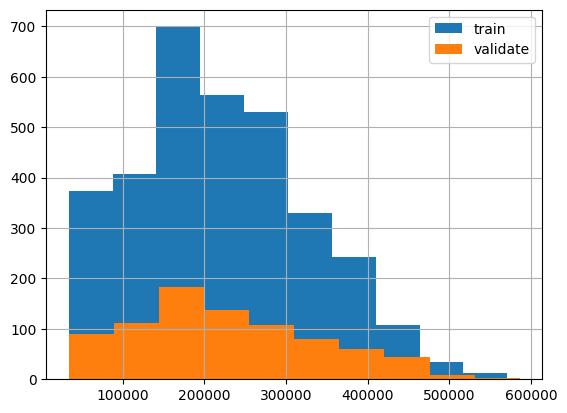

In [196]:
train_validate_data_file_path = 'train_data.csv'

train_validate_dframe = pd.read_csv(
    train_validate_data_file_path,
    delimiter=',',
    usecols=num_cols + cat_cols + [label_col]
)

train_dframe = train_validate_dframe.sample(frac=0.8, random_state=200)
validate_dframe = train_validate_dframe.drop(train_dframe.index)


# plot label_col histogram
train_dframe[label_col].hist()
validate_dframe[label_col].hist()
# add legend
plt.legend(['train', 'validate'])

Sample weight
tensor([7.3969, 1.3621, 7.6543])
Accuracy: 13.52%
Accuracy: 13.33%
Accuracy: 79.78%
Accuracy: 79.03%
Accuracy: 81.42%
Accuracy: 81.82%
Accuracy: 81.42%
Accuracy: 81.82%
Accuracy: 81.45%
Accuracy: 81.94%
Accuracy: 81.45%
Accuracy: 81.94%
Accuracy: 81.45%
Accuracy: 81.94%
Accuracy: 81.42%
Accuracy: 82.06%
Accuracy: 81.51%
Accuracy: 81.45%
Accuracy: 80.27%
Accuracy: 80.73%
Accuracy: 81.90%
Accuracy: 82.55%
Accuracy: 81.66%
Accuracy: 82.18%
Accuracy: 82.72%
Accuracy: 84.24%
Accuracy: 82.66%
Accuracy: 83.52%
Accuracy: 83.27%
Accuracy: 83.88%
Accuracy: 83.27%
Accuracy: 84.48%
Accuracy: 82.81%
Accuracy: 84.00%
Accuracy: 83.30%
Accuracy: 83.76%
Accuracy: 83.12%
Accuracy: 84.61%
Accuracy: 83.33%
Accuracy: 84.85%
Accuracy: 83.48%
Accuracy: 84.48%
Accuracy: 83.54%
Accuracy: 84.61%
Accuracy: 83.48%
Accuracy: 84.12%
Accuracy: 83.57%
Accuracy: 84.24%
Accuracy: 83.42%
Accuracy: 84.61%
Accuracy: 83.87%
Accuracy: 85.82%
Accuracy: 83.33%
Accuracy: 84.12%
Accuracy: 84.09%
Accuracy: 85.33%
A

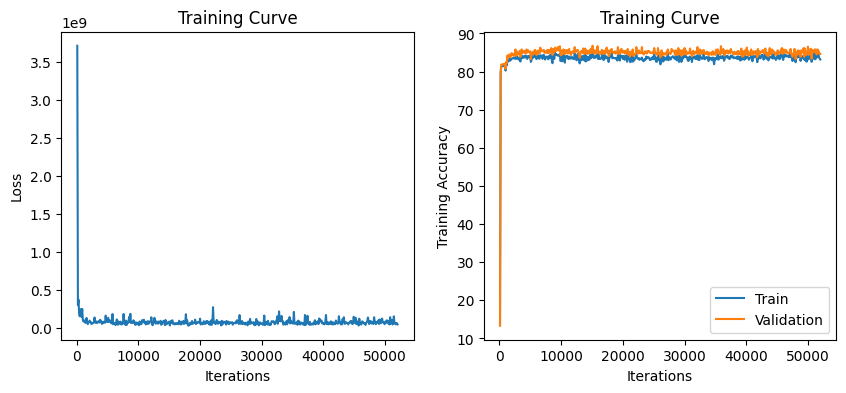

Final Training Accuracy: 83.17671966552734
Final Validation Accuracy: 84.60606384277344


In [197]:
train_validate_data_file_path = 'train_data.csv'

train_validate_dframe = pd.read_csv(
    train_validate_data_file_path,
    delimiter=',',
    usecols=num_cols + cat_cols + [label_col]
)

train_dframe = train_validate_dframe.sample(frac=0.8, random_state=200)
validate_dframe = train_validate_dframe.drop(train_dframe.index)


lr = 1e-3
epoch_count = 1000
batch_size = 64
weight_decay = 0.2
dropout = 0.5
layers = [64, 256, 256, 200, 100, 1]


model = train(train_dframe, validate_dframe, batch_size, epoch_count, lr, weight_decay, dropout, layers)

In [198]:
test_data_file_path = 'test_data.csv'

test_dframe = pd.read_csv(
    test_data_file_path,
    delimiter=',',
    usecols=num_cols + cat_cols
)

# Test dataset
test_num_dframe = test_dframe[num_cols]
test_cat_dframe = pd.get_dummies(test_dframe[cat_cols])

In [206]:
model.load_state_dict(torch.load('model.pth'))

test_dloader = dframe_to_dloader(
    test_num_dframe,
    test_cat_dframe,
    batch_size=batch_size,
    shuffle=False
)

combined_preds = np.empty((0,))
for num_x, cat_x in test_dloader:
    num_x, cat_x = num_x.to(device), cat_x.to(device)
    preds = model.forward(num_x, cat_x)
    preds_classes = assign_classes(preds, bounds).squeeze()
    preds_np = preds_classes.detach().cpu().numpy()
    combined_preds = np.concatenate((combined_preds, preds_np)).astype(int)

np.savetxt('piatek_Kubiszyn_Sobiech.csv', combined_preds, delimiter=',', fmt='%d')

In [202]:
combined_preds

array([1, 1, 2, ..., 0, 1, 1])